# Лабораторная работа 331: Исследование фотоэлементов


In [5]:
import matplotlib.pyplot as polt
import numpy as np
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from rich.console import Console
from rich.panel import Panel
from sklearn import linear_model


console = Console()

In [6]:
# Название фотоэлементов
SCV = "СЦВ-4"  # вакуум
CG = "ЦГ-4"  # газ

In [7]:
experiment_VAC_data: dict[str, dict[str, np.ndarray]] = {
  SCV: {
    # Вольт
    "U": np.array(
      [
        0.109,
        10.215,
        20.09,
        35.18,
        50.15,
        65.11,
        80.15,
        95.11,
        110.19,
        125.04,
        140.31,
        155.24,
        170.22,
        185.17,
        200.35,
        209.95,
        # тут в обратную пошли
        200.41,
        190.29,
        175.14,
        160.34,
        145.08,
        130.26,
        115.3,
        100,
        85.3,
        70.04,
        55.03,
        40.79,
        25.24,
        10.25,
        0.013,
      ]
    ),
    # микро Ампер
    "I": np.array(
      [
        0.09,
        2.6,
        4.15,
        5.77,
        6.91,
        8.15,
        9.01,
        9.04,
        9.07,
        9.09,
        9.10,
        9.12,
        9.14,
        9.16,
        9.18,
        9.19,
        # тут в обратную пошли
        9.19,
        9.18,
        9.17,
        9.15,
        9.14,
        9.13,
        9.11,
        9.09,
        9.07,
        8.86,
        7.29,
        6.36,
        4.92,
        2.82,
        0.05,
      ]
    ),
  },
  CG: {  # Вольт
    "U": np.array(
      [
        0.0011,
        15,
        30.07,
        45,
        60.13,
        75.06,
        90.09,
        105.03,
        120.17,
        135.11,
        150.17,
        165.42,
        180.16,
        190.21,
        200.04,
        # тут в обратную пошли
        185.07,
        170.05,
        155,
        140.16,
        125.18,
        110.22,
        95.07,
        80,
        65.05,
        50.56,
        35.07,
        20.21,
        10.1,
        0.0021,
      ]
    ),
    # микро Ампер
    "I": np.array(
      [
        0.011,
        1.14,
        1.43,
        2.07,
        2.6,
        3.11,
        3.66,
        4.24,
        4.83,
        5.44,
        6.06,
        6.72,
        7.4,
        7.92,
        8.42,
        # тут в обратную пошли
        7.79,
        7.15,
        6.51,
        5.87,
        5.23,
        4.6,
        3.96,
        3.36,
        2.8,
        2.29,
        1.71,
        1.19,
        0.99,
        0,
      ]
    ),
  },
}

experiment_spectral_data: dict[str, dict[str, np.ndarray]] = {
  SCV: {
    # Сантиметр
    "l": np.concatenate([np.arange(0, 23), np.arange(21.5, -0.5, -1), [0]]),
    # микро Ампер
    "I": np.array(
      [
        0.773,
        0.593,
        0.398,
        0.284,
        0.222,
        0.18,
        0.165,
        0.138,
        0.125,
        0.129,
        0.119,
        0.106,
        0.118,
        0.122,
        0.103,
        0.114,
        0.119,
        0.101,
        0.112,
        0.101,
        0.1,
        0.103,
        0.098,
        # тут в обратную пошли
        0.099,
        0.118,
        0.107,
        0.105,
        0.121,
        0.108,
        0.107,
        0.127,
        0.111,
        0.113,
        0.133,
        0.118,
        0.122,
        0.127,
        0.135,
        0.15,
        0.171,
        0.203,
        0.26,
        0.351,
        0.492,
        0.7,
        0.788,
      ]
    ),
  },
  CG: {  # Сантиметр
    "l": np.concatenate([np.arange(0, 23), np.arange(21.5, -0.5, -1), [0]]),
    # микро Ампер
    "I": np.array(
      [
        0.119,
        0.121,
        0.126,
        0.15,
        0.178,
        0.226,
        0.26,
        0.3,
        0.325,
        0.344,
        0.319,
        0.304,
        0.294,
        0.256,
        0.243,
        0.214,
        0.196,
        0.191,
        0.172,
        0.156,
        0.145,
        0.139,
        0.129,
        # тут в обратную пошли
        0.135,
        0.142,
        0.155,
        0.168,
        0.181,
        0.21,
        0.213,
        0.23,
        0.25,
        0.275,
        0.298,
        0.322,
        0.333,
        0.335,
        0.319,
        0.279,
        0.24,
        0.2,
        0.163,
        0.141,
        0.13,
        0.134,
        0.119,
      ]
    ),
  },
}


In [8]:
# Assert data
for data in (experiment_VAC_data, experiment_spectral_data):
  for key in data:
    keys = list(data[key].keys())
    for i in range(len(keys) - 1):
      assert len(data[key][keys[i]]) == len(data[key][keys[i + 1]])
      print(
        f'len(data["{key}"]["{keys[i]}"]) == len(data["{key}"]["{keys[i + 1]}"])'
        f' == "{len(data[key][keys[i]])}"'
      )

len(data["СЦВ-4"]["U"]) == len(data["СЦВ-4"]["I"]) == "31"
len(data["ЦГ-4"]["U"]) == len(data["ЦГ-4"]["I"]) == "29"
len(data["СЦВ-4"]["l"]) == len(data["СЦВ-4"]["I"]) == "46"
len(data["ЦГ-4"]["l"]) == len(data["ЦГ-4"]["I"]) == "46"


In [9]:
l_cap = 0.5  # сантиметра

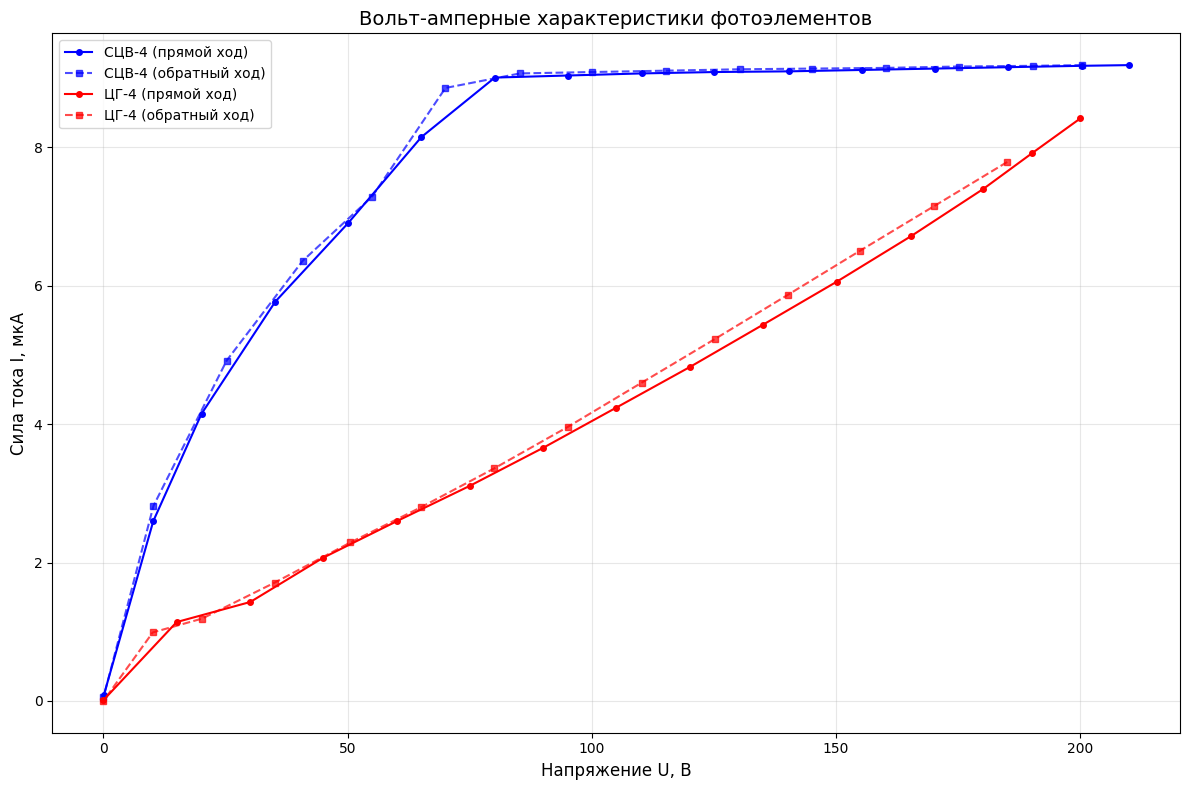

In [10]:
# Создаем график
polt.figure(figsize=(12, 8))

# Цвета для разных фотоэлементов
colors = {SCV: "blue", CG: "red"}

# Построение графиков для каждого фотоэлемента
for element_name, data in experiment_VAC_data.items():
  U = data["U"]
  I = data["I"]

  # Определяем точки разворота (где начинаются обратные ходы)
  if element_name == SCV:
    forward_end = 16  # первые 16 точек - прямой ход
    backward_start = 16  # остальные - обратный
  else:  # CG
    forward_end = 15  # первые 15 точек - прямой ход
    backward_start = 15  # остальные - обратный

  # Разделяем данные на прямой и обратный ход
  U_forward = U[:forward_end]
  I_forward = I[:forward_end]
  U_backward = U[backward_start:]
  I_backward = I[backward_start:]

  # Строим графики
  polt.plot(
    U_forward,
    I_forward,
    marker="o",
    markersize=4,
    linestyle="-",
    linewidth=1.5,
    color=colors[element_name],
    label=f"{element_name} (прямой ход)",
  )

  polt.plot(
    U_backward,
    I_backward,
    marker="s",
    markersize=4,
    linestyle="--",
    linewidth=1.5,
    color=colors[element_name],
    alpha=0.7,
    label=f"{element_name} (обратный ход)",
  )

# Настройки графика
polt.xlabel("Напряжение U, В", fontsize=12)
polt.ylabel("Сила тока I, мкА", fontsize=12)
polt.title("Вольт-амперные характеристики фотоэлементов", fontsize=14)
polt.grid(True, alpha=0.3)
polt.legend(fontsize=10)
polt.tight_layout()

# Показываем график
polt.show()